In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math as math

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *

In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from joblib import parallel_backend

from time import time
from tensorflow.keras.callbacks import TensorBoard
#import warnings
#warnings.filterwarnings('ignore')

In [4]:
from datetime import datetime

In [5]:
from datetime import timedelta

In [6]:
import yfinance as yf

In [7]:
from ipywidgets import interact, widgets

In [8]:
from sklearn.metrics import mean_squared_error, r2_score

## Data loading

In [9]:
sp500 = yf.Ticker("^GSPC")

In [10]:
sp500 = sp500.history(period="max")

In [11]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1950-01-03,16.660000,16.660000,16.660000,16.660000,1260000,0,0
1950-01-04,16.850000,16.850000,16.850000,16.850000,1890000,0,0
1950-01-05,16.930000,16.930000,16.930000,16.930000,2550000,0,0
1950-01-06,16.980000,16.980000,16.980000,16.980000,2010000,0,0
1950-01-09,17.080000,17.080000,17.080000,17.080000,2520000,0,0
...,...,...,...,...,...,...,...
2023-08-17,4416.319824,4421.169922,4364.830078,4370.359863,3943700000,0,0
2023-08-18,4344.879883,4381.819824,4335.310059,4369.709961,3940400000,0,0
2023-08-21,4380.279785,4407.549805,4360.299805,4399.770020,3726850000,0,0


## Cleaning and preparation

In [12]:
#on supprimes les colonnes Dividends et stock splits
del sp500["Dividends"]
del sp500["Stock Splits"]

In [13]:
#on garde que les données après janvier 1990
sp500 = sp500.loc["1990-01-01":].copy()

In [14]:
sp500

,Open,High,Low,Close,Volume
Date,,,,,
1990-01-02,353.399994,359.690002,351.980011,359.690002,162070000
1990-01-03,359.690002,360.589996,357.890015,358.760010,192330000
1990-01-04,358.760010,358.760010,352.890015,355.670013,177000000
1990-01-05,355.670013,355.670013,351.350006,352.200012,158530000
1990-01-08,352.200012,354.239990,350.540009,353.790009,140110000
...,...,...,...,...,...
2023-08-17,4416.319824,4421.169922,4364.830078,4370.359863,3943700000
2023-08-18,4344.879883,4381.819824,4335.310059,4369.709961,3940400000
2023-08-21,4380.279785,4407.549805,4360.299805,4399.770020,3726850000


***

<H3 style="color: cadetblue"> SOME INDICATORS</H3>

<H3 style="color:blue">Tendance générale du S&P 500 depuis janvier 1990</H3>

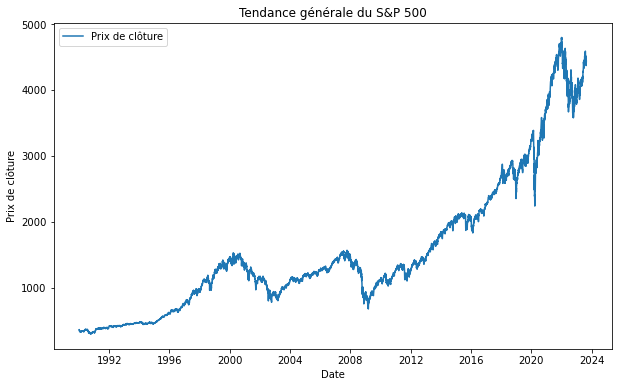

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(sp500.index, sp500['Close'], label='Prix de clôture')
plt.title('Tendance générale du S&P 500')
plt.xlabel('Date')
plt.ylabel('Prix de clôture')
plt.legend()
plt.show()

In [16]:
sp500.index = pd.to_datetime(sp500.index)

In [17]:
interval_data = datetime(2015, 1, 1)

<H3 style="color:blue"> Train data : </H3>

In [18]:
train_data = sp500[sp500.index<interval_data].Close.values

In [19]:
train_data_dates = sp500[sp500.index < interval_data].index.strftime('%Y-%m-%d')

In [20]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data.reshape(-1, 1))

x_train = []
y_train = []

for i in range(10, len(scaled_train_data)):
    x_train.append(scaled_train_data[i - 10:i, 0])
    y_train.append(scaled_train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [21]:
x_train.shape

(6291, 10)

<H3 style="color:blue"> Test data : </H3>

In [22]:
# Créez les données de test

test_data = sp500[sp500.index>=interval_data].Close.values

test_data_dates = sp500[sp500.index>=interval_data].index.strftime('%Y-%m-%d')

In [23]:
scaled_test_data = scaler.transform(test_data.reshape(-1, 1))

x_test = []
y_test = []

for i in range(10, len(scaled_test_data)):
    x_test.append(scaled_test_data[i - 10:i, 0])
    y_test.append(scaled_test_data[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)

In [24]:
test_data_dates

Index(['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08',
       '2015-01-09', '2015-01-12', '2015-01-13', '2015-01-14', '2015-01-15',
       ...
       '2023-08-10', '2023-08-11', '2023-08-14', '2023-08-15', '2023-08-16',
       '2023-08-17', '2023-08-18', '2023-08-21', '2023-08-22', '2023-08-23'],
      dtype='object', name='Date', length=2175)

In [25]:
y_test.shape

(2165,)

### models

<H3 style="color:cadetblue"> LSTM : </H3>

In [26]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [27]:
model.fit(x_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
197/197 [==============================] - 17s 26ms/step - loss: 0.0094
Epoch 2/50
197/197 [==============================] - 5s 24ms/step - loss: 0.0015
Epoch 3/50
197/197 [==============================] - 5s 23ms/step - loss: 0.0014
Epoch 4/50
197/197 [==============================] - 5s 23ms/step - loss: 0.0013
Epoch 5/50
197/197 [==============================] - 5s 23ms/step - loss: 0.0012
Epoch 6/50
197/197 [==============================] - 5s 24ms/step - loss: 0.0012
Epoch 7/50
197/197 [==============================] - 5s 24ms/step - loss: 0.0012
Epoch 8/50
197/197 [==============================] - 5s 24ms/step - loss: 0.0010
Epoch 9/50
197/197 [==============================] - 5s 23ms/step - loss: 9.9112e-04
Epoch 10/50
197/197 [==============================] - 5s 24ms/step - loss: 9.1894e-04
Epoch 11/50
197/197 [==============================] - 5s 24ms/step - loss: 8.5142e-04
Epoch 12/50
197/197 [==============================] - 5s 26ms/step - loss: 8.2275e

In [28]:
loss = model.evaluate(x_test, y_test)
print(f"Loss on test data: {loss}")

68/68 [==============================] - 6s 9ms/step - loss: 0.0015
Loss on test data: 0.001524057355709374


In [29]:
predictions = model.predict(x_test)

68/68 [==============================] - 3s 9ms/step


In [30]:
rmse = mean_squared_error(y_test, predictions, squared=False)
r2 = r2_score(y_test, predictions)

print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")

RMSE: 0.03903917541407801
R-squared: 0.9931041499944578


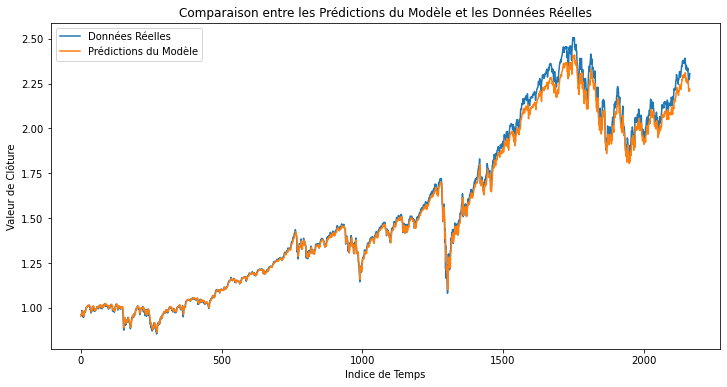

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Données Réelles')
plt.plot(predictions, label='Prédictions du Modèle')
plt.legend()
plt.title("Comparaison entre les Prédictions du Modèle et les Données Réelles")
plt.xlabel("Indice de Temps")
plt.ylabel("Valeur de Clôture")
plt.show()

In [34]:
#from matplotlib.dates import DateFormatter, MonthLocator

# Filtrer les données des 12 derniers mois
last_12_months_dates = test_data_dates[-252:]  # 252 jours correspondant à environ 12 mois
last_12_months_real_values = y_test[-252:]
last_12_months_predictions = predictions[-252:]

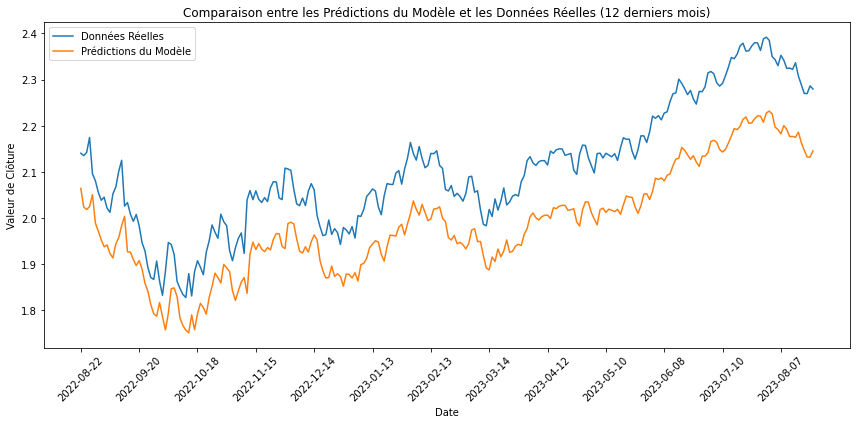

In [35]:
# Plot des données des 12 derniers mois avec des dates mensuelles
plt.figure(figsize=(12, 6))
plt.plot(last_12_months_dates, last_12_months_real_values, label='Données Réelles')
plt.plot(last_12_months_dates, last_12_months_predictions, label='Prédictions du Modèle')
plt.legend()
plt.title("Comparaison entre les Prédictions du Modèle et les Données Réelles (12 derniers mois)")
plt.xlabel("Date")
plt.ylabel("Valeur de Clôture")
plt.xticks(last_12_months_dates[::20], rotation=45)  # Afficher une date sur 20 pour éviter le chevauchement
plt.tight_layout()
plt.show()

### GRU

In [32]:
from keras.models import Sequential
from keras.layers import GRU, Dense

GRU_model = Sequential()
GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
GRU_model.add(GRU(units=50, return_sequences=False))
GRU_model.add(Dense(units=1))
GRU_model.compile(optimizer='adam', loss='mean_squared_error')
GRU_model.fit(x_train, y_train, epochs=50, batch_size=32)


Epoch 1/50
197/197 [==============================] - 14s 21ms/step - loss: 0.0045
Epoch 2/50
197/197 [==============================] - 4s 21ms/step - loss: 1.0644e-04
Epoch 3/50
197/197 [==============================] - 4s 20ms/step - loss: 1.0475e-04
Epoch 4/50
197/197 [==============================] - 4s 21ms/step - loss: 1.0312e-04
Epoch 5/50
197/197 [==============================] - 4s 20ms/step - loss: 9.9643e-05
Epoch 6/50
197/197 [==============================] - 4s 21ms/step - loss: 1.0621e-04
Epoch 7/50
197/197 [==============================] - 4s 21ms/step - loss: 1.0049e-04
Epoch 8/50
197/197 [==============================] - 4s 21ms/step - loss: 9.3739e-05
Epoch 9/50
197/197 [==============================] - 4s 21ms/step - loss: 8.9186e-05
Epoch 10/50
197/197 [==============================] - 4s 21ms/step - loss: 8.5834e-05
Epoch 11/50
197/197 [==============================] - 4s 21ms/step - loss: 9.2596e-05
Epoch 12/50
197/197 [==============================] - 

In [33]:
loss = GRU_model.evaluate(x_test, y_test)
print(f"Loss on test data: {loss}")

68/68 [==============================] - 3s 8ms/step - loss: 0.0017
Loss on test data: 0.0016798105789348483


68/68 [==============================] - 2s 8ms/step


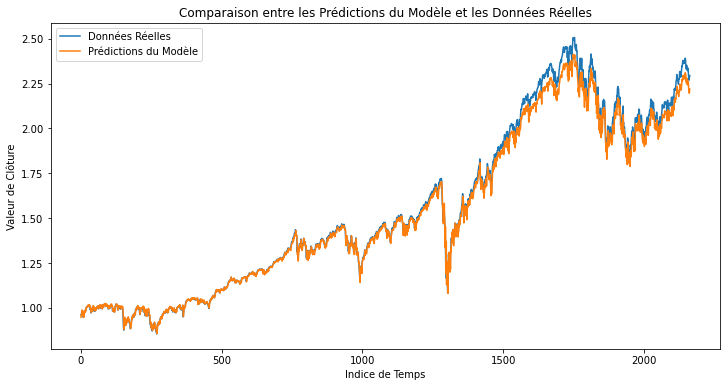

In [34]:
GRU_predictions = GRU_model.predict(x_test)
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Données Réelles')
plt.plot(GRU_predictions, label='Prédictions du Modèle')
plt.legend()
plt.title("Comparaison entre les Prédictions du Modèle et les Données Réelles")
plt.xlabel("Indice de Temps")
plt.ylabel("Valeur de Clôture")
plt.show()

68/68 [==============================] - 1s 9ms/step


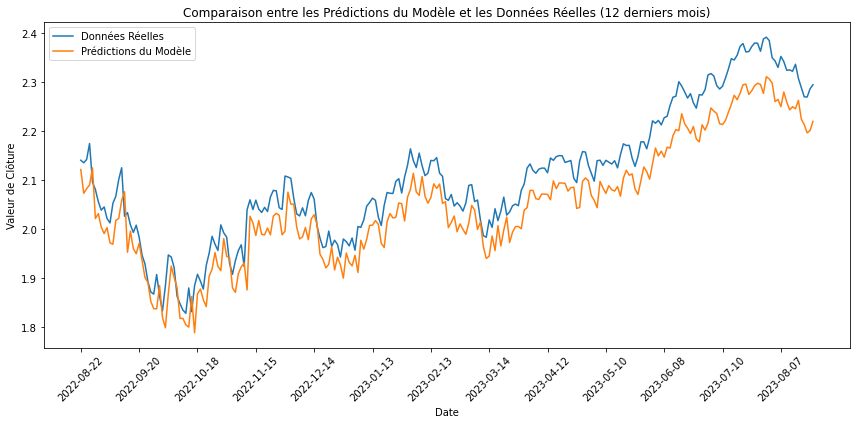

In [35]:
# Plot des données des 12 derniers mois avec des dates mensuelles
GRU_predictions = GRU_model.predict(x_test)
GRU_last_12_months_predictions = GRU_predictions[-252:]
plt.figure(figsize=(12, 6))
plt.plot(last_12_months_dates, last_12_months_real_values, label='Données Réelles')
plt.plot(last_12_months_dates, GRU_last_12_months_predictions, label='Prédictions du Modèle')
plt.legend()
plt.title("Comparaison entre les Prédictions du Modèle et les Données Réelles (12 derniers mois)")
plt.xlabel("Date")
plt.ylabel("Valeur de Clôture")
plt.xticks(last_12_months_dates[::20], rotation=45)  # Afficher une date sur 20 pour éviter le chevauchement
plt.tight_layout()
plt.show()

In [36]:
rmse = mean_squared_error(y_test, GRU_predictions, squared=False)
r2 = r2_score(y_test, GRU_predictions)

print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")

RMSE: 0.04098549435387422
R-squared: 0.9923941554657696


## CNN

In [37]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

input_shape = (x_train.shape[1], 1)
num_classes = 2

CNN = Sequential()
CNN.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
CNN.add(MaxPooling1D(pool_size=2))
CNN.add(LSTM(units=50, return_sequences=True))
CNN.add(Dropout(0.2))
CNN.add(Flatten())
CNN.add(Dense(1, activation='relu'))


CNN.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
CNN.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32)

Epoch 1/50
197/197 [==============================] - 11s 20ms/step - loss: 0.0122 - accuracy: 1.5896e-04 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 2/50
197/197 [==============================] - 2s 12ms/step - loss: 0.0011 - accuracy: 3.1791e-04 - val_loss: 0.0074 - val_accuracy: 0.0000e+00
Epoch 3/50
197/197 [==============================] - 2s 12ms/step - loss: 9.4494e-04 - accuracy: 3.1791e-04 - val_loss: 0.0040 - val_accuracy: 0.0000e+00
Epoch 4/50
197/197 [==============================] - 2s 11ms/step - loss: 7.5583e-04 - accuracy: 3.1791e-04 - val_loss: 0.0100 - val_accuracy: 0.0000e+00
Epoch 5/50
197/197 [==============================] - 2s 11ms/step - loss: 7.2378e-04 - accuracy: 3.1791e-04 - val_loss: 0.0080 - val_accuracy: 0.0000e+00
Epoch 6/50
197/197 [==============================] - 2s 12ms/step - loss: 6.9445e-04 - accuracy: 3.1791e-04 - val_loss: 0.0037 - val_accuracy: 0.0000e+00
Epoch 7/50
197/197 [==============================] - 2s 12ms/step - loss: 6.

68/68 [==============================] - 2s 5ms/step


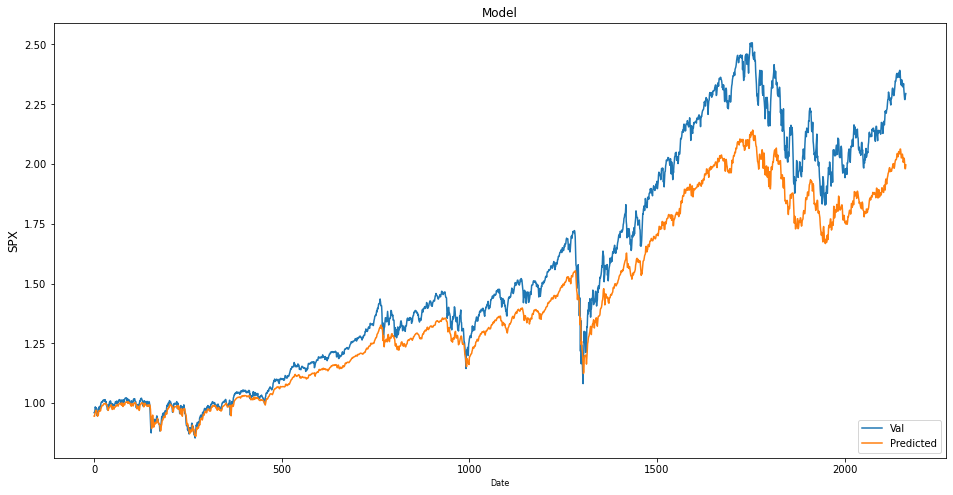

In [38]:
cnn_predicted_stock = CNN.predict(x_test)
predictions_df = pd.DataFrame( columns=['Real', 'Predicted'])
predictions_df['Real'] = y_test
predictions_df['Predicted'] = cnn_predicted_stock

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=8)
plt.ylabel('SPX', fontsize=12)
plt.plot(predictions_df[['Real', 'Predicted']])
plt.legend(['Val', 'Predicted'], loc='lower right')
plt.show()

In [40]:
CNN_last_12_months_predictions = cnn_predicted_stock[-252:]

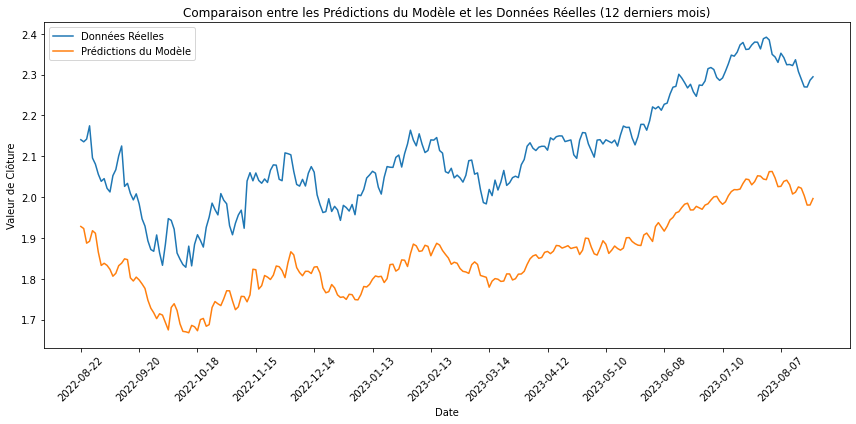

In [41]:
# Plot des données des 12 derniers mois avec des dates mensuelles
plt.figure(figsize=(12, 6))
plt.plot(last_12_months_dates, last_12_months_real_values, label='Données Réelles')
plt.plot(last_12_months_dates, CNN_last_12_months_predictions, label='Prédictions du Modèle')
plt.legend()
plt.title("Comparaison entre les Prédictions du Modèle et les Données Réelles (12 derniers mois)")
plt.xlabel("Date")
plt.ylabel("Valeur de Clôture")
plt.xticks(last_12_months_dates[::20], rotation=45)  # Afficher une date sur 20 pour éviter le chevauchement
plt.tight_layout()
plt.show()

In [39]:
score = r2_score(predictions_df['Real'], predictions_df['Predicted'])
print("R-squared Score:", score)

R-squared Score: 0.8723984208657853


### évaluation

In [42]:
from prettytable import PrettyTable

In [43]:
myTable = PrettyTable(["", "Accuracy", "MSE", "MAE"])

In [44]:
myTable.add_row(["LSTM", 
           str(round(r2_score(y_test, predictions),2)), 
           str(round(mean_squared_error(y_test, predictions),2)), 
           str(round(mean_absolute_error(y_test, predictions),2)),
          ]
         )
myTable.add_row(["GRU", 
           str(round(r2_score(y_test, GRU_predictions),2)), 
           str(round(mean_squared_error(y_test, GRU_predictions),2)), 
           str(round(mean_absolute_error(y_test, GRU_predictions),2)),
          ]
         )
           
myTable.add_row(["CNN", 
           str(round(r2_score(y_test, cnn_predicted_stock),2)), 
           str(round(mean_squared_error(y_test, cnn_predicted_stock),2)), 
           str(round(mean_absolute_error(y_test, cnn_predicted_stock),2)),
          ]
         )
print(myTable)

+------+----------+------+------+
|      | Accuracy | MSE  | MAE  |
+------+----------+------+------+
| LSTM |   0.99   | 0.0  | 0.03 |
| GRU  |   0.99   | 0.0  | 0.03 |
| CNN  |   0.87   | 0.03 | 0.13 |
+------+----------+------+------+


<H3 style="color: cadetblue"> Prédiction futures </H3>

In [64]:

# Date à partir de laquelle commencer l'incrémentation
start_date = pd.to_datetime(test_data_dates[-1]) + timedelta(days=1)

# Nombre de jours à prédire
num_days_to_predict = 100  # Par exemple, pour prédire les 30 prochains jours

# Création de la liste future_dates
future_dates = [start_date + timedelta(days=i) for i in range(num_days_to_predict)]

# Conversion en format de date pour l'affichage
future_dates_str = [date.strftime('%Y-%m-%d') for date in future_dates]

In [65]:
x_future = x_test[-num_days_to_predict:]

In [47]:
x_future.shape

(100, 10)

In [63]:
# Générer les prédictions pour les prochains jours
predictions_future = []

In [66]:
for _ in range(num_days_to_predict):
    #prediction = model.predict(x_future)  # Prédire le prochain jour avec LSTM
    #prediction = GRU_model.predict(x_future)  # Prédire le prochain jour avec GRU
    prediction = CNN.predict(x_future)  # Prédire le prochain jour avec GRU
    
    predictions_future.append(prediction[0, 0])  # Ajouter la valeur prédite à la liste
    # Mettre à jour x_future avec la nouvelle prédiction pour la prochaine itération
    x_future = np.roll(x_future, -1)
    x_future[-1, -1] = prediction[0, 0]


# Préparer les données de test réelles pour les prochains jours
y_test_future = y_test[-num_days_to_predict:]

4/4 [==============================] - 0s 5ms/step


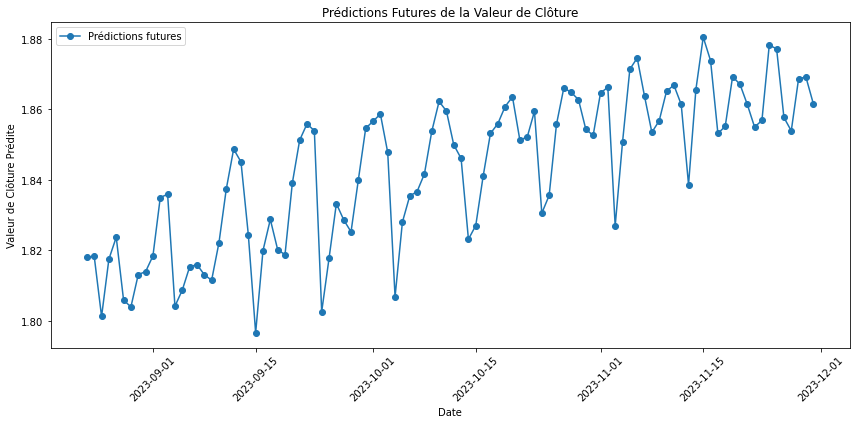

In [67]:
# Créer un DataFrame avec les dates et les prédictions futures
future_df = pd.DataFrame({'Date': future_dates_str, 'Predicted': predictions_future})

# Filtrer les données pour n'inclure que les dates correspondant aux 15 derniers jours de test
future_df = future_df.tail(num_days_to_predict)

# Convertir les dates en format datetime
future_df['Date'] = pd.to_datetime(future_df['Date'])

# Plot des valeurs prédites en fonction des dates
plt.figure(figsize=(12, 6))
plt.plot(future_df['Date'], future_df['Predicted'], marker='o', label='Prédictions futures')
plt.xlabel('Date')
plt.ylabel('Valeur de Clôture Prédite')
plt.title('Prédictions Futures de la Valeur de Clôture')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Stratégy

In [51]:
df = pd.DataFrame({'Date': future_df['Date'], 'Price': future_df['Predicted']})
df.set_index('Date', inplace=True)

In [52]:
# Generate sample data

df = pd.DataFrame({'Date': future_df['Date'], 'Price': future_df['Predicted']})
df.set_index('Date', inplace=True)

In [53]:
# Calculate moving averages
short_window = 10
long_window = 30

df['Short_MA'] = df['Price'].rolling(window=short_window).mean()
df['Long_MA'] = df['Price'].rolling(window=long_window).mean()

# Initialize positions and signals
df['Position'] = 0
df['Signal'] = 0

# Generate signals based on moving average crossover
for i in range(long_window, len(df)):
    if df['Short_MA'][i] > df['Long_MA'][i] and df['Short_MA'][i - 1] <= df['Long_MA'][i - 1]:
        df['Signal'][i] = 1  # Buy signal
    elif df['Short_MA'][i] < df['Long_MA'][i] and df['Short_MA'][i - 1] >= df['Long_MA'][i - 1]:
        df['Signal'][i] = -1  # Sell signal

In [54]:
# Apply signals to positions
position = 0
for i in range(long_window, len(df)):
    if df['Signal'][i] == 1:
        position = 1
    elif df['Signal'][i] == -1:
        position = 0
    df['Position'][i] = position

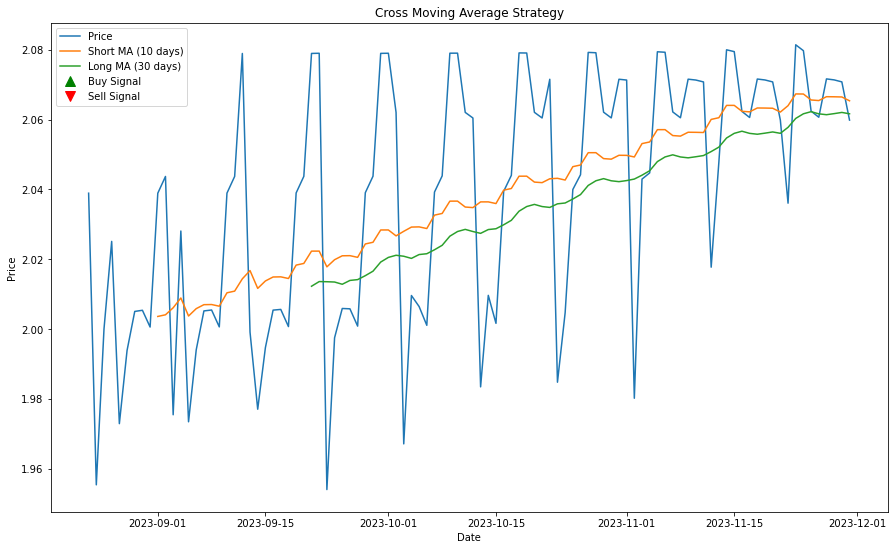

In [55]:
# Plotting
plt.figure(figsize=(15, 9))
plt.plot(df.index, df['Price'], label='Price')
plt.plot(df.index, df['Short_MA'], label=f'Short MA ({short_window} days)')
plt.plot(df.index, df['Long_MA'], label=f'Long MA ({long_window} days)')
plt.plot(df[df['Signal'] == 1].index, df[df['Signal'] == 1]['Price'], '^', markersize=10, color='g', label='Buy Signal')
plt.plot(df[df['Signal'] == -1].index, df[df['Signal'] == -1]['Price'], 'v', markersize=10, color='r', label='Sell Signal')
plt.legend()
plt.title('Cross Moving Average Strategy')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [56]:
from ipywidgets import interact, widgets

In [68]:
# Créez une liste pour stocker les résultats de chaque combinaison
results = []

# Créez une fonction pour appliquer la stratégie en fonction des fenêtres temporelles choisies
def apply_strategy(long_window, short_window):
    # Vérifier que la fenêtre long terme est plus grande que la fenêtre court terme
    if long_window <= short_window:
        print("La fenêtre long terme doit être plus grande que la fenêtre court terme.")
        return
    
    df = pd.DataFrame({'Date': future_df['Date'], 'Price': future_df['Predicted']})
    df.set_index('Date', inplace=True)

    # Calculer les moyennes mobiles à court et long terme
    df['Short_MA'] = df['Price'].rolling(window=short_window).mean()
    df['Long_MA'] = df['Price'].rolling(window=long_window).mean()

    # Initialiser les positions et les signaux
    df['Position'] = 0
    df['Signal'] = 0

    # Générer des signaux basés sur le croisement des moyennes mobiles
    for i in range(long_window, len(df)):
        if df['Short_MA'][i] > df['Long_MA'][i] and df['Short_MA'][i - 1] <= df['Long_MA'][i - 1]:
            df['Signal'][i] = 1  # Signal d'achat
        elif df['Short_MA'][i] < df['Long_MA'][i] and df['Short_MA'][i - 1] >= df['Long_MA'][i - 1]:
            df['Signal'][i] = -1  # Signal de vente

    # Appliquer les signaux aux positions
    position = 0
    for i in range(long_window, len(df)):
        if df['Signal'][i] == 1:
            position = 1
        elif df['Signal'][i] == -1:
            position = 0
        df['Position'][i] = position

    # Afficher le graphique
    plt.figure(figsize=(15, 9))
    plt.plot(df.index, df['Price'], label='Price')
    plt.plot(df.index, df['Short_MA'], label=f'Short MA ({short_window} days)')
    plt.plot(df.index, df['Long_MA'], label=f'Long MA ({long_window} days)')
    plt.plot(df[df['Signal'] == 1].index, df[df['Signal'] == 1]['Price'], '^', markersize=10, color='g', label='Buy Signal')
    plt.plot(df[df['Signal'] == -1].index, df[df['Signal'] == -1]['Price'], 'v', markersize=10, color='r', label=' Sell Signal')
    plt.legend()
    plt.title('Cross Moving Average Strategy')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()
    
    # Calculer le rendement total de la stratégie en points
    total_return = 0
    position = 0
    for i in range(len(df) - 1):
        if df['Position'][i] != position:
            if df['Position'][i] == 1:  # Achat
                total_return -= df['Price'][i]
            else:  # Vente
                total_return += df['Price'][i]
            position = df['Position'][i]
    
    # Ajouter le rendement total à la liste des résultats
    results.append({'Long_Window': long_window, 'Short_Window': short_window, 'Total_Return': total_return})

In [69]:
# Utilisez des widgets interactifs pour permettre à l'utilisateur de choisir les fenêtres temporelles
interact(apply_strategy,
         long_window=widgets.IntSlider(min=10, max=100, step=1, value=30),
         short_window=widgets.IntSlider(min=5, max=50, step=1, value=10))

# Une fois que toutes les combinaisons ont été testées, trouvez la combinaison avec le rendement total le plus élevé
best_combination = max(results, key=lambda x: x['Total_Return'])

# Affichez les résultats de chaque combinaison et la combinaison avec le meilleur rendement
print("Résultats de chaque combinaison :")
for result in results:
    #print(f"Long Window: {result['Long_Window']}, Short Window: {result['Short_Window']}, initil_price: {result['initial_price']},  final_price: {result['final_price']}, Total Return: {result['Total_Return']:.2f} points")
    print(f"Long Window: {result['Long_Window']}, Short Window: {result['Short_Window']}, Total Return: {result['Total_Return']:.2f} points")
    
print("\nLa combinaison avec le meilleur rendement :")
print(f"Long Window: {best_combination['Long_Window']}, Short Window: {best_combination['Short_Window']}, Total Return: {best_combination['Total_Return']:.2f} points")

interactive(children=(IntSlider(value=30, description='long_window', min=10), IntSlider(value=10, description=…

Résultats de chaque combinaison :
Long Window: 30, Short Window: 10, Total Return: 0.00 points

La combinaison avec le meilleur rendement :
Long Window: 30, Short Window: 10, Total Return: 0.00 points


## Indicateurs 

In [132]:
# Calculer les moyennes mobiles à court et long terme
short_window = 12
long_window = 26
sp500['Short_MA'] = sp500['Close'].rolling(window=short_window).mean()
sp500['Long_MA'] = sp500['Close'].rolling(window=long_window).mean()

# Calculer le MACD Line
sp500['MACD_Line'] = sp500['Short_MA'] - sp500['Long_MA']

# Calculer la Signal Line (moyenne mobile exponentielle du MACD Line)
signal_window = 9
sp500['Signal_Line'] = sp500['MACD_Line'].ewm(span=signal_window, adjust=False).mean()

# Calculer l'histogramme MACD
sp500['MACD_Histogram'] = sp500['MACD_Line'] - sp500['Signal_Line']

# Afficher le DataFrame avec les nouvelles colonnes calculées
sp500[-5:]

,Open,High,Low,Close,Volume,Short_MA,Long_MA,MACD_Line,Signal_Line,MACD_Histogram
Date,,,,,,,,,,
2023-08-14,4458.129883,4490.330078,4453.439941,4489.720215,3896410000,4512.446655,4516.412692,-3.966036,24.183908,-28.149944
2023-08-15,4478.870117,4478.870117,4432.189941,4437.859863,3832250000,4500.415812,4517.502310,-17.086498,15.929826,-33.016324
2023-08-16,4433.790039,4449.950195,4403.549805,4404.330078,3753910000,4485.029989,4516.158860,-31.128872,6.518087,-37.646959
2023-08-17,4416.319824,4421.169922,4364.830078,4370.359863,3943700000,4467.832479,4512.243465,-44.410986,-3.667728,-40.743258
2023-08-18,4344.879883,4372.169922,4335.310059,4365.700195,901040690,4455.524984,4506.691932,-51.166948,-13.167572,-37.999377


In [46]:
test_date = datetime(2023, 1, 1)

In [47]:
sp500_kpi = sp500[sp500.index>=test_date]

In [48]:
sp500_kpi

,Open,High,Low,Close,Volume,Short_MA,Long_MA,MACD_Line,Signal_Line,MACD_Histogram,Signal
Date,,,,,,,,,,,
2023-01-03,3853.290039,3878.459961,3794.330078,3824.139893,3959140000,3838.202494,3923.536152,-85.333657,-55.474257,-29.859400,-1
2023-01-04,3840.360107,3873.159912,3815.770020,3852.969971,4414080000,3834.637492,3916.876531,-82.239039,-60.827214,-21.411825,-1
2023-01-05,3839.739990,3839.739990,3802.419922,3808.100098,3893450000,3830.949158,3910.882690,-79.933533,-64.648477,-15.285055,-1
2023-01-06,3823.370117,3906.189941,3809.560059,3895.080078,3923560000,3837.400838,3908.476929,-71.076090,-65.934000,-5.142091,-1
2023-01-09,3910.820068,3950.570068,3890.419922,3892.090088,4311770000,3843.273336,3901.245389,-57.972054,-64.341611,6.369557,1
...,...,...,...,...,...,...,...,...,...,...,...
2023-08-17,4416.319824,4421.169922,4364.830078,4370.359863,3943700000,4467.832479,4512.243465,-44.410986,-3.667728,-40.743258,-1
2023-08-18,4344.879883,4381.819824,4335.310059,4369.709961,3940400000,4455.859131,4506.846154,-50.987023,-13.131587,-37.855436,-1
2023-08-21,4380.279785,4407.549805,4360.299805,4399.770020,3726850000,4447.349121,4502.782696,-55.433575,-21.591984,-33.841591,-1


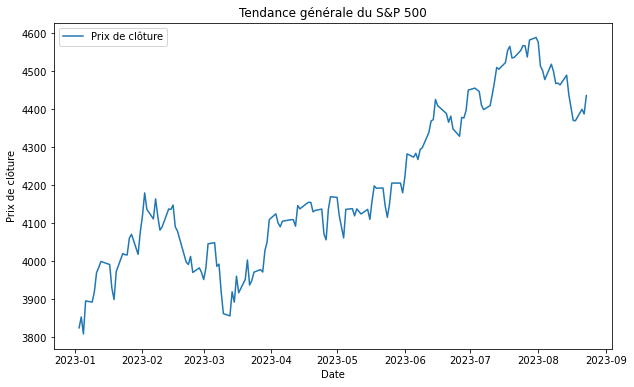

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(sp500_kpi.index, sp500_kpi['Close'], label='Prix de clôture')
plt.title('Tendance générale du S&P 500')
plt.xlabel('Date')
plt.ylabel('Prix de clôture')
plt.legend()
plt.show()

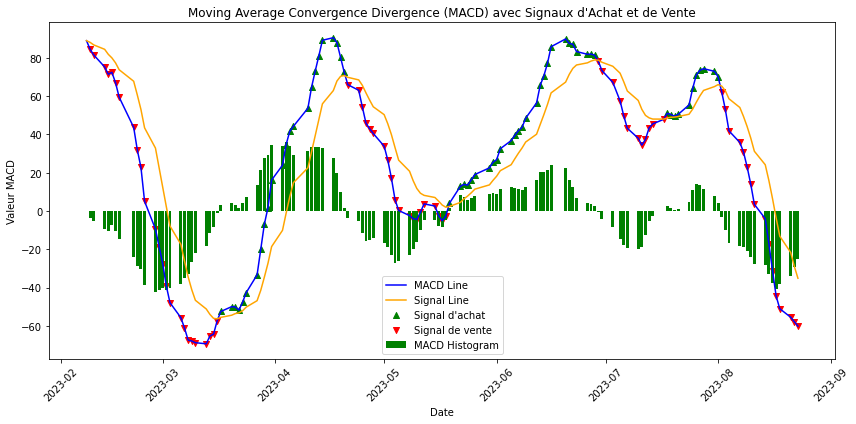

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

# Supposons que vous avez déjà chargé les données dans un DataFrame sp500 avec une colonne 'Close' contenant les prix de clôture
df = pd.DataFrame()

# Calculer les moyennes mobiles à court et long terme
short_window = 12
long_window = 26
df['Short_MA'] = sp500_kpi['Close'].rolling(window=short_window).mean()
df['Long_MA'] = sp500_kpi['Close'].rolling(window=long_window).mean()

# Calculer le MACD Line
df['MACD_Line'] = df['Short_MA'] - df['Long_MA']

# Calculer la Signal Line (moyenne mobile exponentielle du MACD Line)
signal_window = 9
df['Signal_Line'] = df['MACD_Line'].ewm(span=signal_window, adjust=False).mean()

# Calculer l'histogramme MACD
df['MACD_Histogram'] = df['MACD_Line'] - df['Signal_Line']

# Tracer le graphique du MACD avec les signaux d'achat (vert) et de vente (rouge)
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['MACD_Line'], label='MACD Line', color='blue')
plt.plot(df.index, df['Signal_Line'], label='Signal Line', color='orange')
plt.bar(df.index, df['MACD_Histogram'], label='MACD Histogram', color='green')

# Ajouter les signaux d'achat (vert) et de vente (rouge)
buy_signals = df[df['MACD_Line'] > df['Signal_Line']]
sell_signals = df[df['MACD_Line'] < df['Signal_Line']]
plt.scatter(buy_signals.index, buy_signals['MACD_Line'], marker='^', color='green', label='Signal d\'achat')
plt.scatter(sell_signals.index, sell_signals['MACD_Line'], marker='v', color='red', label='Signal de vente')

plt.legend()
plt.title('Moving Average Convergence Divergence (MACD) avec Signaux d\'Achat et de Vente')
plt.xlabel('Date')
plt.ylabel('Valeur MACD')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
